In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import copy 
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

from multiprocessing import set_start_method
import multiprocessing as mp
import os

import warnings
warnings.filterwarnings('ignore')

try:
    set_start_method("forkserver")
except:
    pass

os.environ["OMP_NUM_THREADS"] = "8"

In [2]:
xgb1, xgb1_h1, xgb1_h2 = pickle.load(open("./core_models/xgb1.pkl", "rb"))
regr1, regr1_h1, regr1_h2 = pickle.load(open("./core_models/regr1.pkl", "rb"))
xgb1_columns = pickle.load(open("./core_models/xgb1_columns.pkl", "rb"))
regr1_columns = pickle.load(open("./core_models/regr1_columns.pkl", "rb"))
models = [xgb1, regr1]

In [3]:
# Read source data
data_training_full = pd.read_pickle('/mnt/disks/disk1/data_train_1209.pkl').iloc[1:,:]

data_h1 = data_training_full.iloc[:data_training_full.shape[0]//2,:].sample(frac=0.2).sort_index()
data_h2 = data_training_full.iloc[data_training_full.shape[0]//2:,:].sample(frac=0.2).sort_index()

data = data_h1.append(data_h2)

In [4]:
print(np.sum(data_h1.iloc[1,:5] != data.iloc[1,:5]))
print(np.sum(data_h2.iloc[-2,:5] != data.iloc[-2,:5]))

0
0


In [8]:
%%time

n_splits = 3

def model_fcast_kfold(dtrain, model, predictors, n_splits):
    train_pred = np.empty((0,1), float)
    kf_split = KFold(n_splits=n_splits)

    for (train_index, test_index) in kf_split.split(dtrain):
        model.fit(dtrain.iloc[train_index][predictors], dtrain.iloc[train_index]['y'])
        test_predictions = model.predict(dtrain.iloc[test_index][predictors])
        train_pred = np.append(train_pred, test_predictions)
    
    return train_pred

stack_df_h1 = pd.DataFrame()
stack_df_h2 = pd.DataFrame()
stack_df_h1['y'] = data_h1['y']
stack_df_h2['y'] = data_h2['y']

stack_df_h1['regr_h1_pred'] = model_fcast_kfold(data_h1, copy.deepcopy(regr1_h1), regr1_columns, n_splits)
stack_df_h2['regr_h1_pred'] = regr1_h1.predict(data_h2[regr1_columns])

stack_df_h1['regr_h2_pred'] = regr1_h2.predict(data_h1[regr1_columns])
stack_df_h2['regr_h2_pred'] = model_fcast_kfold(data_h2, copy.deepcopy(regr1_h2), regr1_columns, n_splits)

stack_df_h1['xgb_h1_pred'] = model_fcast_kfold(data_h1, copy.deepcopy(xgb1_h1), xgb1_columns, n_splits)
stack_df_h2['xgb_h1_pred'] = xgb1_h1.predict(data_h2[xgb1_columns])

stack_df_h1['xgb_h2_pred'] = xgb1_h2.predict(data_h1[xgb1_columns])
stack_df_h2['xgb_h2_pred'] = model_fcast_kfold(data_h2, copy.deepcopy(xgb1_h2), xgb1_columns, n_splits)

stack_df = stack_df_h1.append(stack_df_h2)
stack_df['xgb_pred'] = model_fcast_kfold(data, copy.deepcopy(xgb1), xgb1_columns, n_splits)
stack_df['regr_full_pred'] = model_fcast_kfold(data, copy.deepcopy(regr1), regr1_columns, n_splits)

CPU times: user 13h 29min 41s, sys: 1min 33s, total: 13h 31min 14s
Wall time: 1h 42min 48s


In [3]:
# stack_df.to_pickle('/mnt/disks/disk1/data_stacking_1309.pkl')
stack_df = pd.read_pickle('/mnt/disks/disk1/data_stacking_1309.pkl')

In [4]:
print(metrics.r2_score(stack_df['y'].values, stack_df['xgb_pred'].values))
print(metrics.r2_score(stack_df['y'].values, stack_df['xgb_h1_pred'].values))
print(metrics.r2_score(stack_df['y'].values, stack_df['xgb_h2_pred'].values))
print(metrics.r2_score(stack_df['y'].values, stack_df['regr_full_pred'].values))
print(metrics.r2_score(stack_df['y'].values, stack_df['regr_h1_pred'].values))
print(metrics.r2_score(stack_df['y'].values, stack_df['regr_h2_pred'].values))
# print('XGB Forecast - right model for the sample')
# print(metrics.r2_score(stack_df_h1['y'].values, stack_df_h1['xgb_h1_pred'].values))
# print(metrics.r2_score(stack_df_h2['y'].values, stack_df_h2['xgb_h2_pred'].values))
# print('XGB Forecast - wrong model for the sample')
# print(metrics.r2_score(stack_df_h2['y'].values, stack_df_h2['xgb_h1_pred'].values))
# print(metrics.r2_score(stack_df_h1['y'].values, stack_df_h1['xgb_h2_pred'].values))
# print('Elnet Forecast - right model for the sample')
# print(metrics.r2_score(stack_df_h1['y'].values, stack_df_h1['regr_h1_pred'].values))
# print(metrics.r2_score(stack_df_h2['y'].values, stack_df_h2['regr_h2_pred'].values))
# print('Elnet Forecast - wrong model for the sample')
# print(metrics.r2_score(stack_df_h2['y'].values, stack_df_h2['regr_h1_pred'].values))
# print(metrics.r2_score(stack_df_h1['y'].values, stack_df_h1['regr_h2_pred'].values))
# print('')
# print(metrics.r2_score(stack_df['regr_h1_pred'].values, stack_df['regr_h2_pred'].values))
# print(metrics.r2_score(stack_df['xgb_pred'].values, stack_df['regr_h2_pred'].values))
# print(metrics.r2_score(stack_df['xgb_pred'].values, stack_df['regr_h1_pred'].values))
# print(metrics.r2_score(stack_df['regr_full_pred'].values, stack_df['regr_h1_pred'].values))
# print(metrics.r2_score(stack_df['regr_full_pred'].values, stack_df['regr_h2_pred'].values))

0.022629472332958644
0.020181847694933586
0.01914359963817336
0.018416416464690277
0.01763488583139372
0.0046423746182651104


In [5]:
def model_wf_cv(alg, dtrain, predictors, target, n_splits):
    tscv = KFold(n_splits=n_splits) #TimeSeriesSplit
    cv_scores_test = np.zeros((n_splits, 1))
    cv_scores_train = np.zeros((n_splits, 1))
    cv_scores_r2_test = np.zeros((n_splits, 1))
    
    for i, (train_index, test_index) in enumerate(tscv.split(dtrain)):
        
        alg.fit(dtrain.iloc[train_index][predictors], 
                dtrain.iloc[train_index][target])
        
        test_predictions = alg.predict(dtrain.iloc[test_index][predictors])
        train_predictions = alg.predict(dtrain.iloc[train_index][predictors])
        
        cv_scores_test[i, 0] = metrics.mean_squared_error(dtrain.iloc[test_index][target].values, 
                                                             test_predictions)
        cv_scores_train[i, 0] = metrics.mean_squared_error(dtrain.iloc[train_index][target].values, 
                                                             train_predictions)
        cv_scores_r2_test[i, 0] = metrics.r2_score(dtrain.iloc[test_index][target].values, 
                                                             test_predictions)
        # print('\t\t{}\{}'.format(cv_scores_test[i, 0], cv_scores_train[i, 0]))
        
    return np.sqrt(np.mean(cv_scores_train)), np.sqrt(np.mean(cv_scores_test)), np.mean(cv_scores_r2_test)

def grid_search_rmse(alg, dtrain, predictors, target, n_splits, parameters):
    best_score = np.inf
    for g in ParameterGrid(parameters):
        print(g)
        alg.set_params(**g)
        wf_cv_score_train, wf_cv_score_test, wf_cv_score_test_r2 = model_wf_cv(alg, dtrain, predictors, target, n_splits)
        if(wf_cv_score_test < best_score):
            best_score = wf_cv_score_test
            best_grid = g
        print("\tCV score test: %f (R2 %f)\tCV score train: %f"%(wf_cv_score_test, wf_cv_score_test_r2, wf_cv_score_train))
    return best_score, best_grid

In [7]:
predictors = [
    'xgb_pred',
    'xgb_h1_pred',
    'xgb_h2_pred',
    'regr_full_pred',
    'regr_h1_pred',
    'regr_h2_pred'
]

svr = SVR(kernel='rbf')

gridsearch_df = stack_df.sample(frac=0.1).sort_index()
print(metrics.r2_score(gridsearch_df['y'].values, gridsearch_df['xgb_pred'].values))


0.022063417883265823


In [6]:
%%time

params_svr = {
    'gamma': [1e-2, 1e-1, 1, 10], 
    'C': [1e-2, 1e-1, 1, 10]
}

print(grid_search_rmse(copy.deepcopy(svr), gridsearch_df, 
                       predictors, 'y', 3, params_svr))

0.022026914819194943
{'C': 0.01, 'gamma': 0.01}
	CV score test: 0.699413 (R2 0.012194)	CV score train: 0.702634
{'C': 0.01, 'gamma': 0.1}
	CV score test: 0.696469 (R2 0.020507)	CV score train: 0.699868
{'C': 0.01, 'gamma': 1}
	CV score test: 0.696358 (R2 0.020778)	CV score train: 0.699628
{'C': 0.01, 'gamma': 10}
	CV score test: 0.696900 (R2 0.019259)	CV score train: 0.700047
{'C': 0.1, 'gamma': 0.01}
	CV score test: 0.696453 (R2 0.020552)	CV score train: 0.699851
{'C': 0.1, 'gamma': 0.1}
	CV score test: 0.696131 (R2 0.021419)	CV score train: 0.699415
{'C': 0.1, 'gamma': 1}
	CV score test: 0.696321 (R2 0.020905)	CV score train: 0.699611
{'C': 0.1, 'gamma': 10}
	CV score test: 0.696660 (R2 0.019940)	CV score train: 0.699236
{'C': 1, 'gamma': 0.01}
	CV score test: 0.696112 (R2 0.021475)	CV score train: 0.699418
{'C': 1, 'gamma': 0.1}
	CV score test: 0.696093 (R2 0.021511)	CV score train: 0.699328
{'C': 1, 'gamma': 1}
	CV score test: 0.696285 (R2 0.021040)	CV score train: 0.699438
{'C': 1

In [8]:
params_svr = {
    'gamma': [1e-3, 1e-2], 
    'C': [5, 10, 20]
}

print(grid_search_rmse(copy.deepcopy(svr), gridsearch_df, 
                       predictors, 'y', 3, params_svr))

{'C': 5, 'gamma': 0.001}
	CV score test: 0.703009 (R2 0.022256)	CV score train: 0.702799
{'C': 5, 'gamma': 0.01}
	CV score test: 0.702948 (R2 0.022438)	CV score train: 0.702717
{'C': 10, 'gamma': 0.001}
	CV score test: 0.702971 (R2 0.022367)	CV score train: 0.702750
{'C': 10, 'gamma': 0.01}
	CV score test: 0.702949 (R2 0.022432)	CV score train: 0.702713
{'C': 20, 'gamma': 0.001}
	CV score test: 0.702948 (R2 0.022435)	CV score train: 0.702727
{'C': 20, 'gamma': 0.01}
	CV score test: 0.702958 (R2 0.022395)	CV score train: 0.702714
(0.7029475654382352, {'C': 5, 'gamma': 0.01})


In [9]:
%%time

svr.set_params(C=5, gamma=0.01)

train_df = stack_df.sample(frac=0.3).sort_index()
svr.fit(train_df[predictors], train_df['y'])
pickle.dump(svr, open("./core_models/svr1.pkl", "wb"))

CPU times: user 22min 14s, sys: 200 ms, total: 22min 14s
Wall time: 22min 14s


In [ ]:
pred = svr.predict(stack_df[predictors])

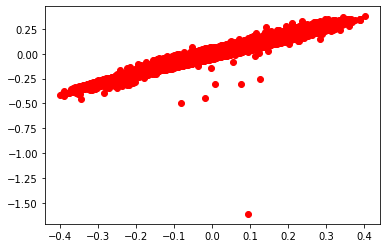

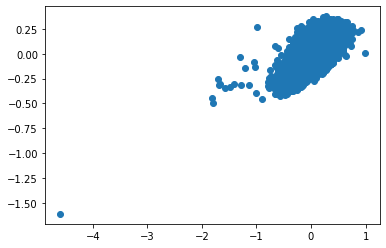

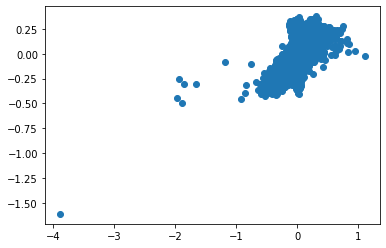

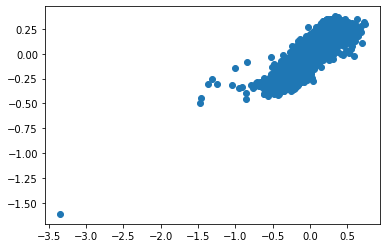

In [26]:
plt.figure()
plt.plot(stack_df['xgb_pred'], pred, 'ro')

plt.figure()
plt.plot(stack_df['regr_h1_pred'], pred, 'o')

plt.figure()
plt.plot(stack_df['regr_h2_pred'], pred, 'o')

plt.figure()
plt.plot(stack_df['regr_full_pred'], pred, 'o')